In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects


#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'


import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod
from gewitter_functions import get_acc

2023-10-27 15:33:57.456756: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ds_train = xr.open_dataset('/rc_scratch/reba1583/CNN_data_limitNoAR/train.nc').isel(time = slice(0,2000))

ds_val = xr.open_dataset('/rc_scratch/reba1583/CNN_data_limitNoAR/validate.nc')

In [7]:
train_random_shuffle = np.arange(len(ds_train.features))
np.random.shuffle(train_random_shuffle )

X_train = ds_train.features.values[train_random_shuffle]
Y_train = ds_train.labels_1d.values[train_random_shuffle]
time_train = ds_train.time[train_random_shuffle]

val_random_shuffle = np.arange(len(ds_val.features))
np.random.shuffle(val_random_shuffle)
X_val = ds_val.features.values[val_random_shuffle]
Y_val = ds_val.labels_1d.values[val_random_shuffle]
time_val = ds_val.time[val_random_shuffle]

In [8]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, utils.to_categorical(Y_train)))
val_data = tf.data.Dataset.from_tensor_slices((X_val, utils.to_categorical(Y_val)))

In [9]:
#batch both 
batch_size = 32
train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)

In [10]:
for batch in train_data:
    break 
for batch in val_data:
    break 

2023-10-27 15:34:35.995360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [2000,11]
	 [[{{node Placeholder/_1}}]]
2023-10-27 15:34:36.131771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1733,11]
	 [[{{node Placeholder/_1}}]]


<tf.Tensor: shape=(11,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

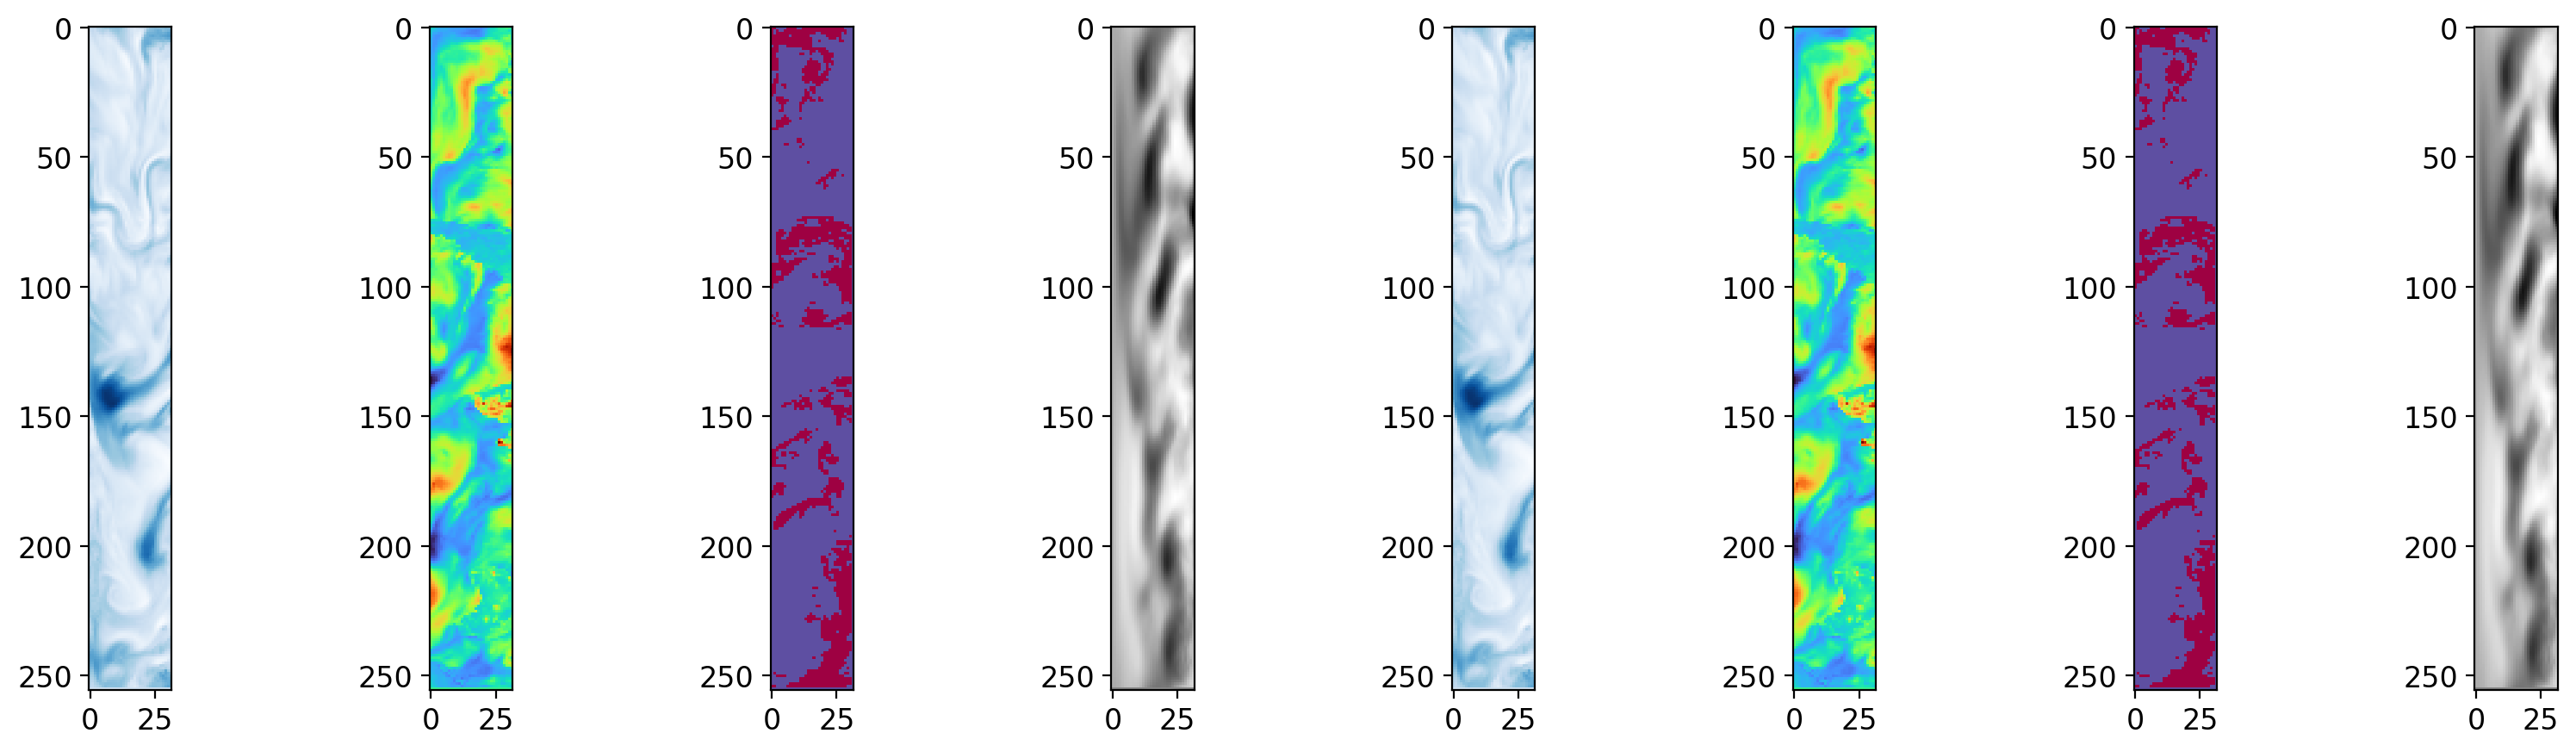

In [11]:
#get the features for example 12 in this batch 
one_example_features = batch[0][5]
#get the label for that same example 
one_example_label = batch[1][5]


fig,axes = plt.subplots(1,8,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')
axes[4].imshow(one_example_features[:,:,0],cmap='Blues')
axes[5].imshow(one_example_features[:,:,1],cmap='turbo')
axes[6].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[7].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label

In [102]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Conv2D(10,kernel_size=5,activation='relu',input_shape=(train_data.element_spec[0].shape[1:]),),

    
        #need to flatten/ravel the 2d image into a 1d vector 
        tf.keras.layers.Flatten(),
    
        #add two dense layers (which is the same as an ANN)
        tf.keras.layers.Dense(16,activation='relu'),
        tf.keras.layers.Dropout(0.33),
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.Dropout(0.33),
        
        #output layer 
        tf.keras.layers.Dense(11,activation='softmax')
        ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 252, 28, 10)       2010      
                                                                 
 flatten_2 (Flatten)         (None, 70560)             0         
                                                                 
 dense_6 (Dense)             (None, 16)                1128976   
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                544       
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 11)               

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, (3, 3), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),

    tf.keras.layers.Conv2D(10, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Add max pooling layer

    tf.keras.layers.Conv2D(20, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),

    tf.keras.layers.Conv2D(20, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Add max pooling layer

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation='relu'),  # Add dense layer
    tf.keras.layers.Dropout(0.5),  # Add dropout layer
    tf.keras.layers.Dense(128, activation='relu'),  # Add dense layer
    tf.keras.layers.Dropout(0.5),  # Add dropout layer
    tf.keras.layers.Dense(10, activation='softmax'),
                           
    #add two dense layers (which is the same as an ANN)
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.33),

    #output layer 
    tf.keras.layers.Dense(11,activation='softmax')
])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 32, 10)       730       
                                                                 
 batch_normalization (BatchN  (None, 256, 32, 10)      40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 32, 10)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 32, 10)       910       
                                                                 
 batch_normalization_1 (Batc  (None, 256, 32, 10)      40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 32, 10)       0

In [14]:

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), metrics=['accuracy'])

history = model.fit(train_data,validation_data=val_data,epochs=10)




Epoch 1/10
63/63 [==============================] - 23s 337ms/step - loss: 2.3892 - accuracy: 0.1050 - val_loss: 2.3754 - val_accuracy: 0.1200
Epoch 2/10
63/63 [==============================] - 21s 341ms/step - loss: 2.3706 - accuracy: 0.1285 - val_loss: 2.3597 - val_accuracy: 0.1200
Epoch 3/10
63/63 [==============================] - 21s 331ms/step - loss: 2.3618 - accuracy: 0.1235 - val_loss: 2.3523 - val_accuracy: 0.1316
Epoch 4/10
63/63 [==============================] - 21s 339ms/step - loss: 2.3538 - accuracy: 0.1290 - val_loss: 2.3479 - val_accuracy: 0.1235
Epoch 5/10
63/63 [==============================] - 19s 304ms/step - loss: 2.3522 - accuracy: 0.1190 - val_loss: 2.3450 - val_accuracy: 0.1218
Epoch 6/10
63/63 [==============================] - 19s 301ms/step - loss: 2.3523 - accuracy: 0.1190 - val_loss: 2.3429 - val_accuracy: 0.1218
Epoch 7/10
63/63 [==============================] - 20s 315ms/step - loss: 2.3488 - accuracy: 0.1190 - val_loss: 2.3407 - val_accuracy: 0.1212

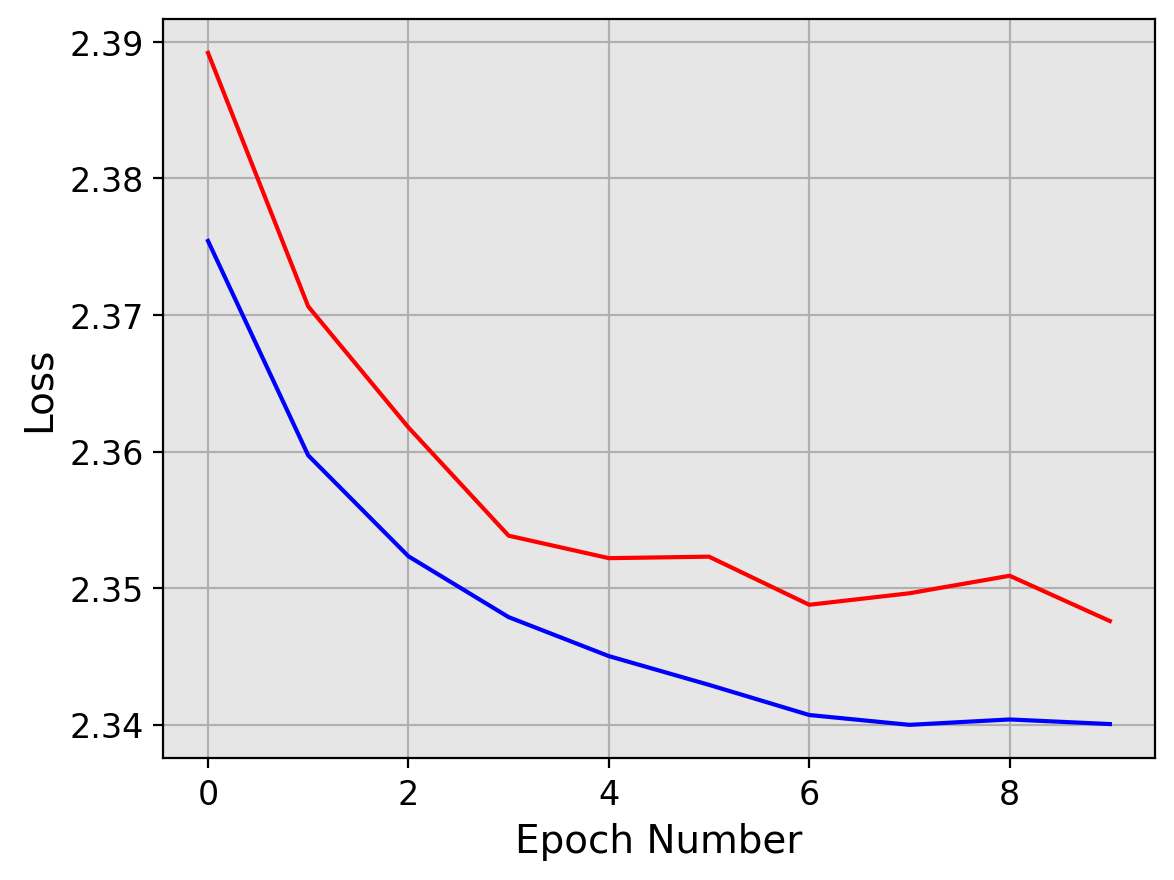

In [15]:
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

## Figure out some better ways to looks at outcome

In [107]:
#like sklearn, we do .predict!
y_preds_distribution = model.predict(val_data)

55/55 [==============================] - 3s 62ms/step


In [109]:
y_preds = np.argmax(y_preds_distribution, axis = 1)

In [138]:
results_pd = pd.DataFrame(y_preds_distribution)
results_pd 

,0,1,2,3,4,5,6,7,8,9,10
0,0.124256,0.086173,0.101071,0.121487,0.109530,0.078229,0.035620,0.078485,0.077418,0.116017,0.071715
1,0.125540,0.084310,0.100941,0.122982,0.108512,0.078731,0.034654,0.078210,0.077434,0.117449,0.071238
2,0.124502,0.086130,0.100946,0.121202,0.109198,0.078514,0.035842,0.078607,0.077470,0.115833,0.071756
3,0.124526,0.085781,0.101128,0.121658,0.109358,0.078297,0.035357,0.078382,0.077420,0.116418,0.071674
4,0.124071,0.085579,0.101625,0.122612,0.110286,0.077656,0.034712,0.078275,0.077309,0.116550,0.071325
...,...,...,...,...,...,...,...,...,...,...,...
1728,0.124224,0.085838,0.101197,0.121809,0.109620,0.078204,0.035347,0.078423,0.077442,0.116289,0.071607
1729,0.124747,0.085700,0.101063,0.121495,0.109077,0.078513,0.035450,0.078460,0.077457,0.116348,0.071691
1730,0.124189,0.085735,0.101315,0.122112,0.109879,0.077995,0.035101,0.078325,0.077387,0.116445,0.071518
1731,0.124120,0.086386,0.101000,0.121202,0.109464,0.078316,0.035908,0.078548,0.077452,0.115777,0.071828


In [139]:
results_pd.insert(0,'predY_3',np.flip(np.argsort(y_preds_distribution, axis =1))[:,2])
results_pd.insert(0,'predY_2',np.flip(np.argsort(y_preds_distribution, axis =1))[:,1])
results_pd.insert(0,'predY_1',np.argmax(y_preds_distribution, axis = 1))
results_pd.insert(0,'trueY',Y_val)
results_pd.insert(0,'timestep',np.array(time_val))

In [140]:
results_pd

,timestep,trueY,predY_1,predY_2,predY_3,0,1,2,3,4,5,6,7,8,9,10
0,2003-01-29 18:00:00,3,0,3,9,0.124256,0.086173,0.101071,0.121487,0.109530,0.078229,0.035620,0.078485,0.077418,0.116017,0.071715
1,1993-10-23 12:00:00,4,0,3,9,0.125540,0.084310,0.100941,0.122982,0.108512,0.078731,0.034654,0.078210,0.077434,0.117449,0.071238
2,1980-01-18 18:00:00,5,0,3,9,0.124502,0.086130,0.100946,0.121202,0.109198,0.078514,0.035842,0.078607,0.077470,0.115833,0.071756
3,1988-05-20 12:00:00,3,0,3,9,0.124526,0.085781,0.101128,0.121658,0.109358,0.078297,0.035357,0.078382,0.077420,0.116418,0.071674
4,1982-02-21 18:00:00,5,0,3,9,0.124071,0.085579,0.101625,0.122612,0.110286,0.077656,0.034712,0.078275,0.077309,0.116550,0.071325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,1980-09-22 18:00:00,8,0,3,9,0.124224,0.085838,0.101197,0.121809,0.109620,0.078204,0.035347,0.078423,0.077442,0.116289,0.071607
1729,1998-10-13 18:00:00,2,0,3,9,0.124747,0.085700,0.101063,0.121495,0.109077,0.078513,0.035450,0.078460,0.077457,0.116348,0.071691
1730,2013-09-06 18:00:00,5,0,3,9,0.124189,0.085735,0.101315,0.122112,0.109879,0.077995,0.035101,0.078325,0.077387,0.116445,0.071518
1731,2013-03-09 00:00:00,8,0,3,9,0.124120,0.086386,0.101000,0.121202,0.109464,0.078316,0.035908,0.078548,0.077452,0.115777,0.071828


In [120]:
np.flip(np.argsort(y_preds_distribution[1000])) == np.flip(np.argsort(y_preds_distribution[400]))

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True])

In [100]:
np.flip(np.argsort(y_preds_distribution[:,0]))

InvalidIndexError: (slice(None, None, None), 0)

In [97]:
np.unique(np.flip(np.argsort(y_preds_distribution, axis =1)), axis=1)[1]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
Y_train = ds_train.labels_1d.values[train_random_shuffle]
time_train = ds_train.time[train_random_shuffle]


In [18]:
#the contingency table calculator expects y_true,y_pred
cont_table = get_contingency_table(Y_val,y_preds)

accuracy = get_acc(cont_table)
print('Accuracy = {}%'.format(np.round(accuracy,0)))

Accuracy = 56.0%


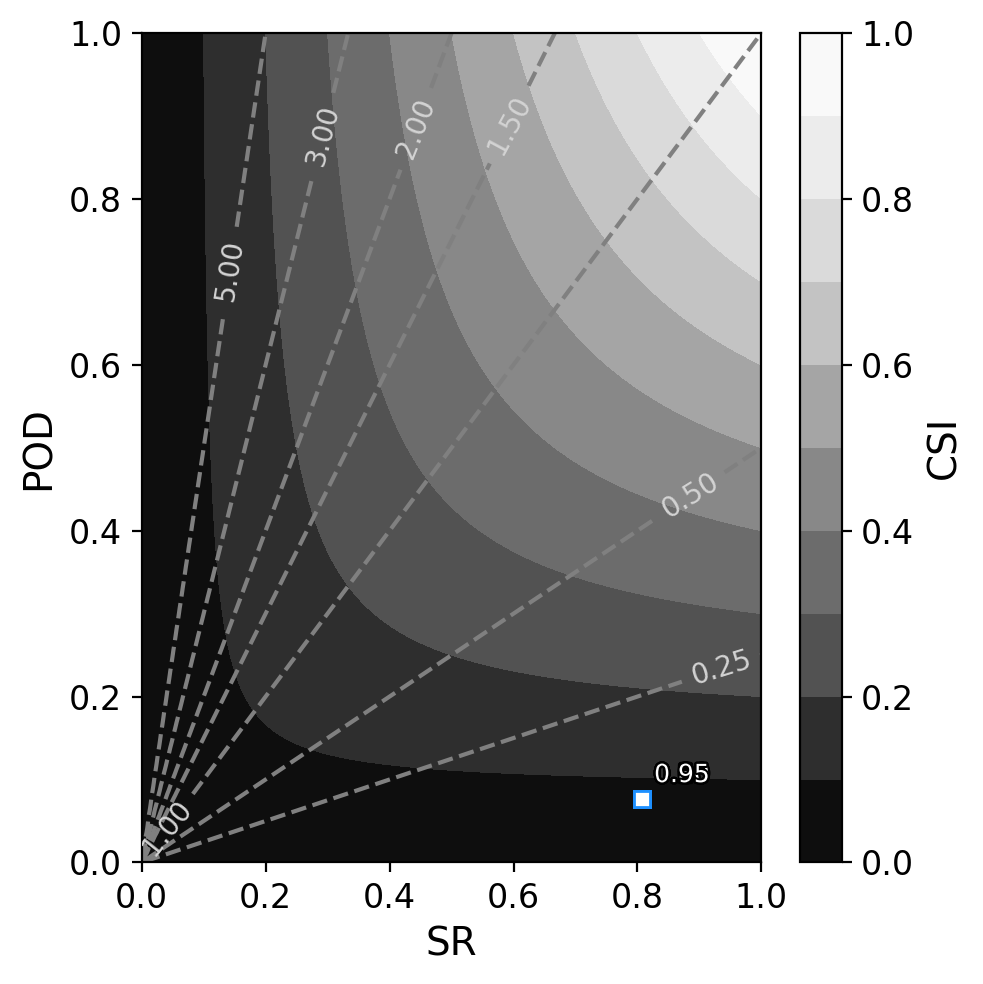

In [19]:
#import some helper functions for our other directory.
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(Y_val,y_preds)
fps = fp(Y_val,y_preds)
fns = fn(Y_val,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')

#load contingency_table func

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    if np.mod(i,3)==0:
        text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
        ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

In [20]:
#grab layer 1 weights, which are the convolution filters. 
filters = model.weights[0]

filters.shape

TensorShape([3, 3, 8, 10])

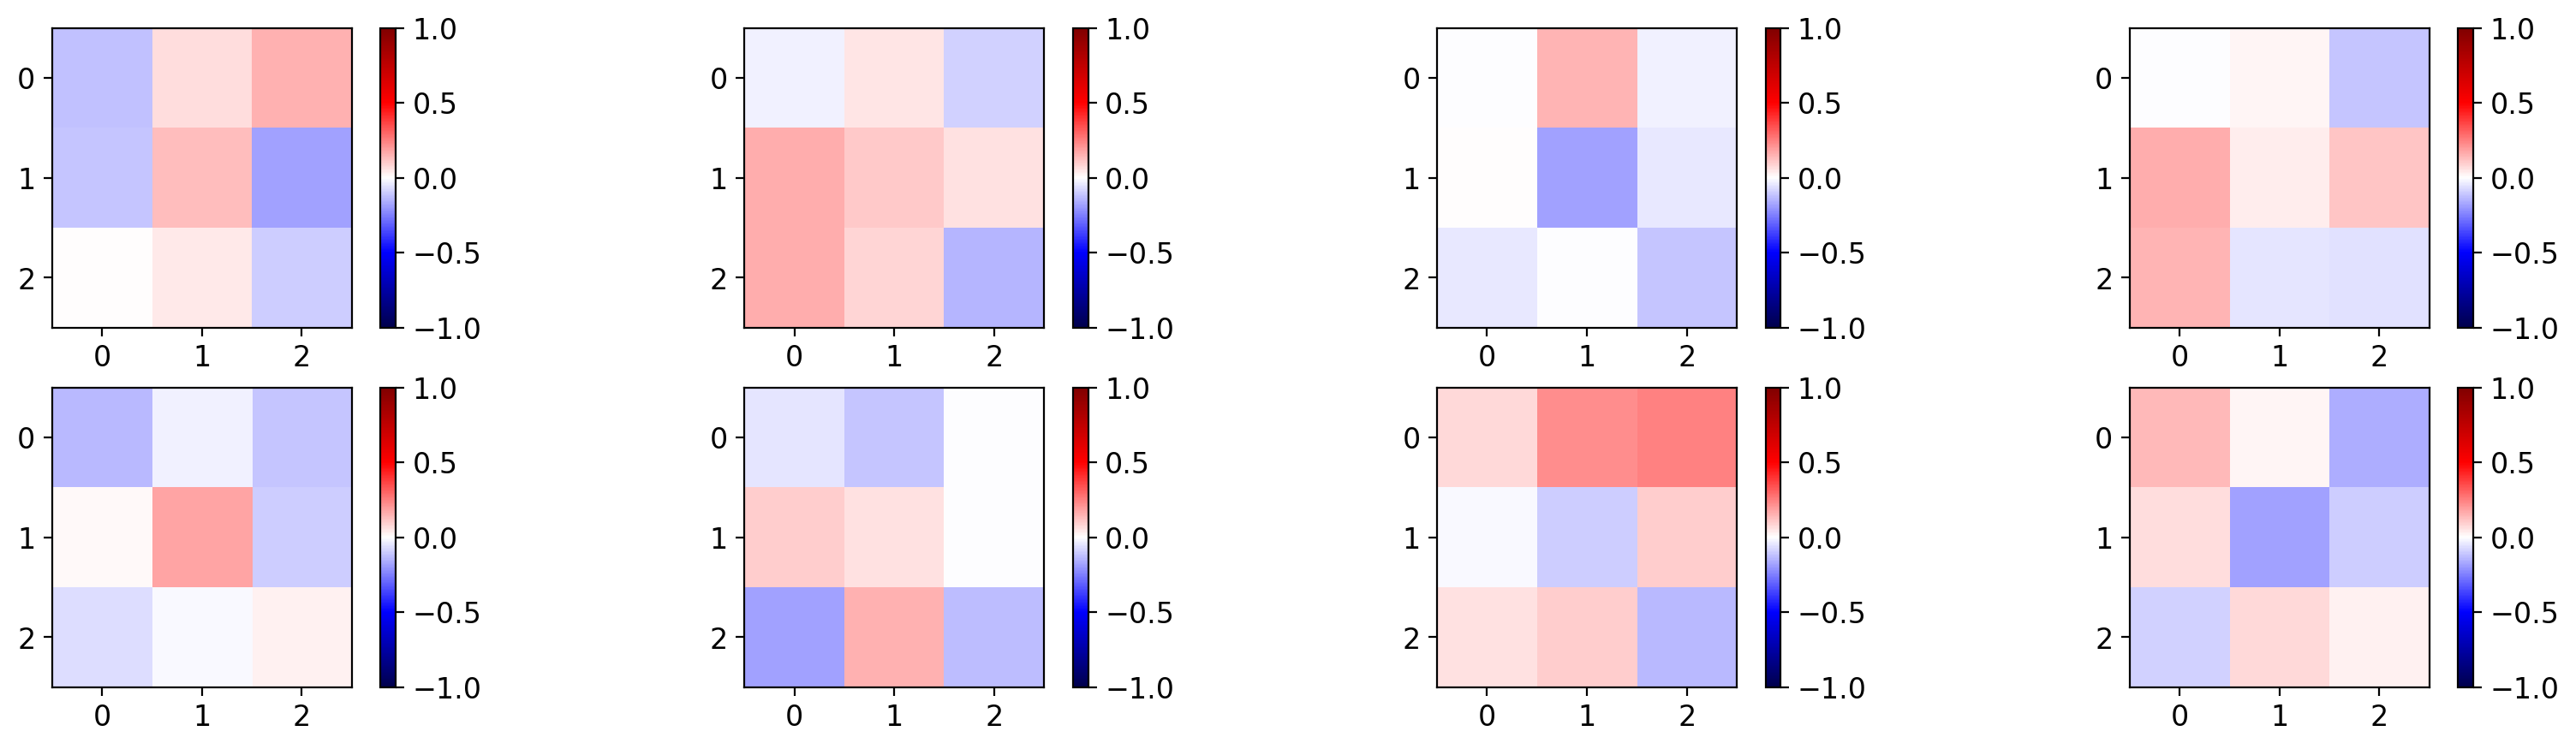

In [21]:
fig,axes = plt.subplots(2,4,figsize=(20,5))
axes = axes.flatten()
for i in np.arange(0,8):
    pm = axes[i].imshow(filters[:,:,i,0],vmin=-1,vmax=1,cmap='seismic')
    plt.colorbar(pm,ax=axes[i])
    

In [22]:
## Checkout certain layer 
for l,layer in enumerate(model.layers):
    print(l,layer.name)

0 conv2d
1 batch_normalization
2 leaky_re_lu
3 conv2d_1
4 batch_normalization_1
5 leaky_re_lu_1
6 max_pooling2d
7 conv2d_2
8 batch_normalization_2
9 leaky_re_lu_2
10 conv2d_3
11 batch_normalization_3
12 leaky_re_lu_3
13 max_pooling2d_1
14 global_average_pooling2d
15 dropout
16 dense
17 dropout_1
18 dense_1
19 dropout_2
20 dense_2
21 dense_3
22 dropout_3
23 dense_4
24 dropout_4
25 dense_5


In [24]:
#identify the convolutional layer
conv_layer = model.get_layer('conv2d_3')

#re-wire a model to take the normal model inputs, but now just output the result of the convolution
conv_output = tf.keras.models.Model([model.inputs], [conv_layer.output])

#run the model the same way, to see what the output convovled image
convolved_images = conv_output.predict(val_data)

#grab a batch to look at 
for batch in val_data:
    break 

55/55 [==============================] - 5s 91ms/step


In [25]:
convolved_images = convolved_images[:,:,:,-1]

In [72]:
n = 4

Text(0, 0.5, 'Predicted Likelihood')

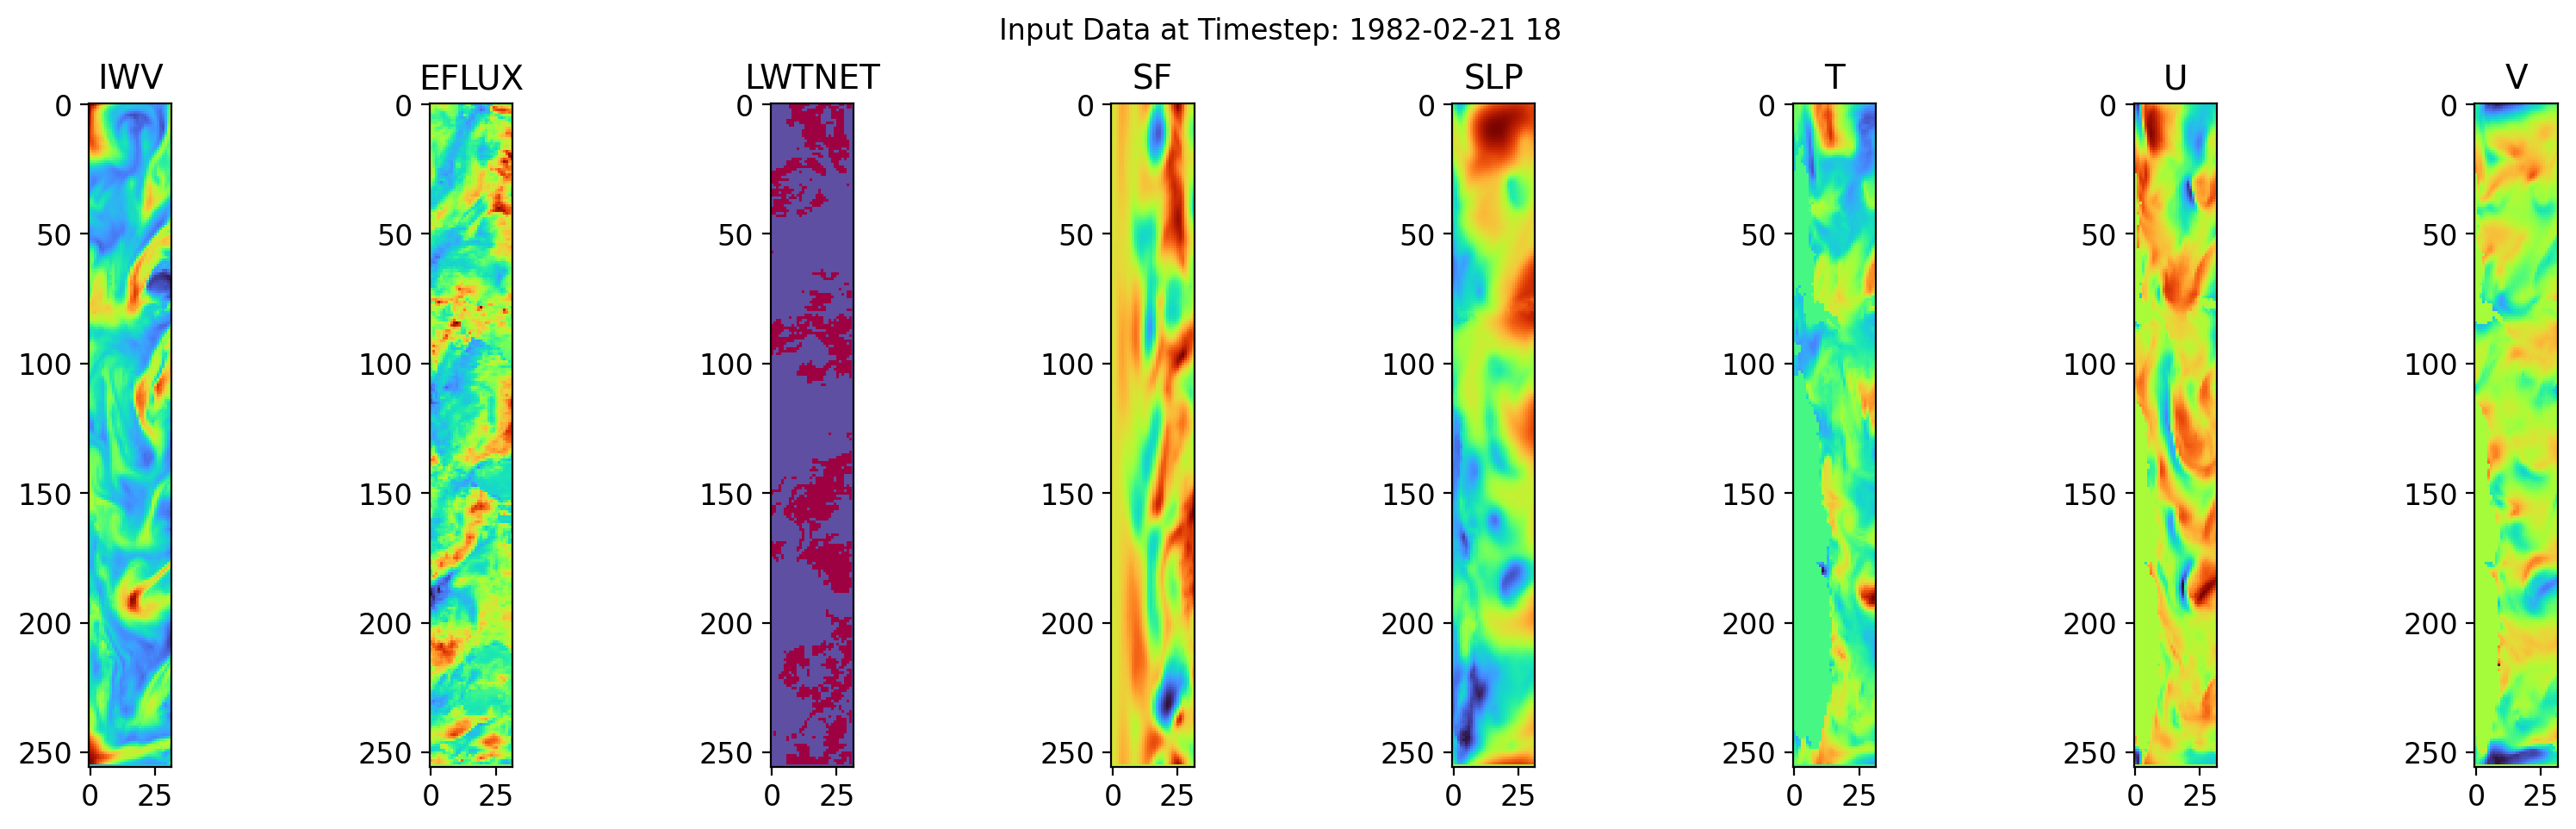

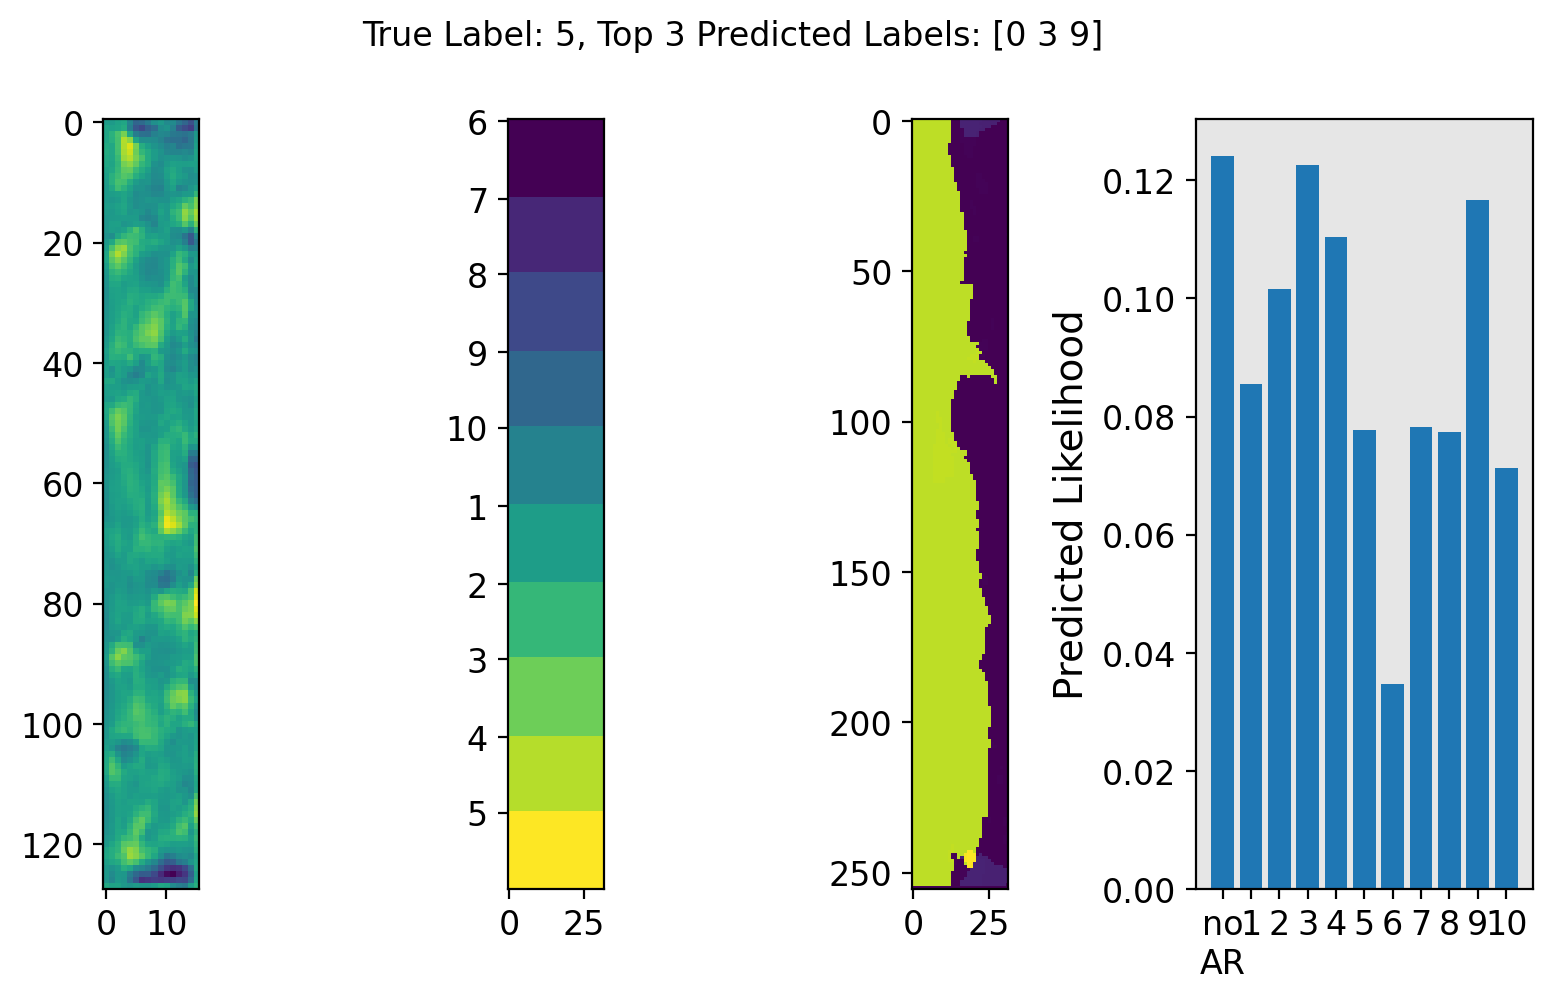

In [73]:
Y_visual_data = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Y_labels_AR_PRECSN_T/'+str(pd.to_datetime(time_val[n].values).year))
Y_visual_data = Y_visual_data.sel(time = time_val[n].values).Y.values.T

# Make category visual
lons = np.shape(batch[0])[1]
start = np.round(np.arange(0,lons,lons/10))
end = np.round(np.arange(lons/10,lons+lons/10, lons/10))
show_categories = np.zeros((np.shape(batch[0])[0:2][1],np.shape(batch[0])[0:2][0]))
for c in range(10):
    show_categories[int(start[c]):int(end[c]),:] = c+1

#get the features for example 12 in this batch 
one_example_features = batch[0][n]
#get the label for that same example 
one_example_label = batch[1][n]

titles = ['IWV', 'EFLUX', 'LWTNET', 'SF', 'SLP', 'T', 'U', 'V']

fig,axes = plt.subplots(1,8,figsize=(20,5))
fig.suptitle('Input Data at Timestep: '+str(pd.to_datetime(time_val[n].values))[0:13])
axes = axes.flatten()
axes[0].imshow(one_example_features[:,:,0],cmap='turbo')
axes[0].set_title(titles[0])
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[1].set_title(titles[1])
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[2].set_title(titles[2])
axes[3].imshow(one_example_features[:,:,3],cmap='turbo')
axes[3].set_title(titles[3])
axes[4].imshow(one_example_features[:,:,4],cmap='turbo')
axes[4].set_title(titles[4])
axes[5].imshow(one_example_features[:,:,5],cmap='turbo')
axes[5].set_title(titles[5])
axes[6].imshow(one_example_features[:,:,6],cmap='turbo')
axes[6].set_title(titles[6])
axes[7].imshow(one_example_features[:,:,7],cmap='turbo')
axes[7].set_title(titles[7])



fig,axes = plt.subplots(1,4,figsize=(10,5))
fig.suptitle('True Label: '+str(int(np.argwhere(one_example_label.numpy()==1)))+', Top 3 Predicted Labels: '+str(np.flip(np.argsort(y_preds_distribution[n]))[0:3]) )
axes = axes.flatten()
axes[0].imshow(convolved_images[n])
axes[1].imshow(show_categories)
axes[1].set_yticks(np.round(np.arange(0,lons,lons/10)))
axes[1].set_yticklabels(['6','7','8','9','10','1','2','3','4','5',]);
axes[1].imshow(show_categories)
axes[2].imshow(Y_visual_data)

axes[3].bar(np.arange(0,11,1),y_preds_distribution[n])
axes[3].set_xticks(np.arange(0,11,1), ['no\nAR','1','2','3','4','5','6','7','8','9','10']);
axes[3].set_ylabel('Predicted Likelihood')